In [2]:
import time
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
import yfinance as yf
import datetime
import os

In [3]:
general_stocks = ['KO', 'PFE', 'WMT', 'PG', 'JNJ', 'DIS', 'PEP', 'MCD', 'T', 'VZ']
tech_stocks = ['AAPL', 'AMZN', 'MSFT', 'GOOGL', 'NVDA', 'TSLA', 'META', 'INTC', 'IBM', 'AMD']
finance_stocks = ['GS', 'BAC', 'WFC', 'USB', 'JPM', 'MA', 'V', 'AXP', 'C', 'BLK']
decentralized_currencies = ['BTC', 'ETH', 'ADA', 'BNB', 'SOL', 'XRP', 'DOGE', 'XMR', 'LTC', 'SHIB']

general_stocks_names = ['Coca-Cola', 'Pfizer', 'Walmart', 'Procter & Gamble', 'Johnson & Johnson', 'Disney', 'Pepsi', 'McDonalds', 'AT&T', 'Verizon']
tech_stocks_names = ['Apple', 'Amazon', 'Microsoft', 'Google', 'Nvidia', 'Tesla', 'Meta', 'Intel', 'IBM', 'AMD']
finance_stocks_names = ['Goldman Sachs', 'Bank of America', 'Wells Fargo', 'US Bancorp', 'JPMorgan Chase', 'Mastercard', 'Visa', 'American Express', 'Citigroup', 'BlackRock']
decentralized_currencies_names = ['Bitcoin', 'Ethereum', 'Cardano', 'Binance Coin', 'Solana', 'Ripple', 'Dogecoin', 'Monero', 'Litecoin', 'Shiba Inu']

color_map = {
    'general': 'deepskyblue',
    'tech': 'limegreen',
    'finance': 'darkorchid',
    'crypto': 'red'
}

In [4]:
def get_trends_data(keyword, 
                    timeframe=datetime.date.today().strftime('%Y-%m-%d') + ' ' + (datetime.date.today() - datetime.timedelta(days = 269)).strftime('%Y-%m-%d'),
                    retries=5, 
                    backoff_factor=1.0):
    pytrends = TrendReq(hl='en-US', tz=360, timeout=(10,25), )
    pytrends.build_payload(keyword, cat = 0, timeframe = timeframe, geo='')
    
    for i in range(retries):
        try:
            df = pytrends.interest_over_time()
            if df is not None and not df.empty:
                print(f"Trend Data for {keyword} retrieved successfully.")
                df.reset_index(inplace = True)
                df.rename(columns = {'date': 'Date', keyword[0]: 'Trend'}, inplace = True)
                df['Date'] = pd.to_datetime(df['Date'].dt.strftime('%m/%d/%Y'))
                return df
            else:
                print("No data retrieved or DataFrame is empty.")
                return None
        except Exception as e:
            if "429" in str(e):
                sleep_time = backoff_factor * (2 ** i)
                print(f"Rate limit exceeded. Retrying in {sleep_time} seconds...")
                time.sleep(sleep_time)
            else:
                raise(f"An error occurred: {e}")
    print("Failed to retrieve data after several retries.")
    return None

In [5]:
def get_stock_data(ticker, start, end):
    currTicker = yf.Ticker(ticker)
    tickerDF = currTicker.history(repair = True, start = start, end = end, auto_adjust = False).drop(columns = ['Dividends', 'Stock Splits', 'Repaired?']).reset_index()
    print(f"Stock Data for {ticker} retrieved successfully.")
    tickerDF['Date'] = pd.to_datetime(tickerDF['Date'].dt.strftime('%m/%d/%Y'))
    return tickerDF

In [8]:
def trend_corr(stock, days = 60, start = '2023-10-01', end = '2024-06-01', delay = 7):
    if not os.path.exists(f"./Data/{stock}_trends({start} - {end}).csv"):
        if stock in general_stocks:
            name = general_stocks_names[general_stocks.index(stock)]
        elif stock in tech_stocks:
            name = tech_stocks_names[tech_stocks.index(stock)]
        elif stock in finance_stocks:
            name = finance_stocks_names[finance_stocks.index(stock)]
        else:
            name = decentralized_currencies_names[decentralized_currencies.index(stock)]
        t = get_trends_data([name], timeframe = f"{start} {end}")
        if t is None:
            raise Exception(f'Failed to retrieve Trend Data of {stock}.')
        t.to_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    else:
        t = pd.read_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    if not os.path.exists(f"./Data/{stock}_Prices({start} - {end}).csv"):
        if stock in decentralized_currencies:
            p = get_stock_data(f'{stock}-USD', start = start, end = end)
        else:
            p = get_stock_data(stock, start = start, end = end)
        p.to_csv(f"./Data/{stock}_Prices({start} - {end}).csv")
    else:
        p = pd.read_csv(f"./Data/{stock}_Prices({start} - {end}).csv")

    t['Date'] = pd.to_datetime(t['Date'])
    p['Date'] = pd.to_datetime(p['Date'])

    full_data = pd.merge(p, t, on='Date')

    full_data['log_returns'] = np.log(full_data.Close / full_data.Close.shift(1))
    full_data['Volatility'] = full_data['log_returns'].rolling(window=days).std() * np.sqrt(days)

    for i in range(1, 8):
        full_data[f'Delay_{i}'] = full_data['Trend'].shift(i)

    rho = full_data.corr()
    rho_c = rho['Close'][f'Delay_{delay}']
    return rho_c, full_data

In [9]:
def plot_stock_data(stock, days = 60, start = '2023-10-01', end = '2024-06-01', delay = 7, download = False):
    if not os.path.exists(f"./Data/{stock}_trends({start} - {end}).csv"):
        if stock in general_stocks:
            name = general_stocks_names[general_stocks.index(stock)]
        elif stock in tech_stocks:
            name = tech_stocks_names[tech_stocks.index(stock)]
        elif stock in finance_stocks:
            name = finance_stocks_names[finance_stocks.index(stock)]
        else:
            name = decentralized_currencies_names[decentralized_currencies.index(stock)]
        t = get_trends_data([name], timeframe = f"{start} {end}")
        t.to_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    else:
        t = pd.read_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    if not os.path.exists(f"./Data/{stock}_Prices({start} - {end}).csv"):
        p = get_stock_data(stock, start = start, end = end)
        p.to_csv(f"./Data/{stock}_Prices({start} - {end}).csv")
    else:
        p = pd.read_csv(f"./Data/{stock}_Prices({start} - {end}).csv")

    t['Date'] = pd.to_datetime(t['Date'])
    p['Date'] = pd.to_datetime(p['Date'])

    full_data = pd.merge(p, t, on='Date')

    full_data['log_returns'] = np.log(full_data.Close / full_data.Close.shift(1))
    full_data['Volatility'] = full_data['log_returns'].rolling(window=days).std() * np.sqrt(days)

    full_data[f'Delay_{delay}'] = full_data.Trend.shift(7)

    # Determine the color based on the stock category
    if stock in general_stocks:
        color = color_map['general']
        name = general_stocks_names[general_stocks.index(stock)]
    elif stock in tech_stocks:
        color = color_map['tech']
        name = tech_stocks_names[tech_stocks.index(stock)]
    elif stock in finance_stocks:
        color = color_map['finance']
        name = finance_stocks_names[finance_stocks.index(stock)]
    else:
        color = color_map['crypto']
        name = decentralized_currencies_names[decentralized_currencies.index(stock)]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Plot Close price
    axes[0].plot(full_data['Date'], full_data['Close'], label = 'Close Price', color = color)
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Close Price')
    axes[0].set_title(f'{stock}: Close Price')
    legend = axes[0].legend(loc='upper left')
    legend.get_frame().set_alpha(0.3)

    # Plot 7-days delay trend
    axes[1].plot(full_data['Date'], full_data[f'Delay_{delay}'], label = f'{delay}-Days Delayed Trend', color = 'black')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel(f'{delay}-Days Delayed Trend')
    axes[1].set_title(f'{stock}: {delay}-Days Delayed Trend')
    legend = axes[1].legend(loc='upper right')
    legend.get_frame().set_alpha(0.3)

    fig.suptitle(f'{name} ({stock})', fontsize=20, verticalalignment = 'bottom', fontweight = 'bold')
    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(top=0.95)
    if download:
        plt.savefig(f"./Plots/{stock}_plot({start} - {end}).png", bbox_inches='tight')
    plt.show()

$$Normalized\;Value=\frac{search\;value\;for\;term}{total\;Search\;Volume} * 100$$

and then each one devided by the max

In [124]:
display(bitcoinDFs[0])
display(bitcoinDFs[1])
display(bitcoinDFs[2])
display(bitcoinDFs[3])
display(bitcoinDFs[4])
display(bitcoinDFs[5])
display(bitcoinDFs[6])

,Date,Trend
0,2019-06-23,50
1,2019-06-24,51
2,2019-06-25,59
3,2019-06-26,100
4,2019-06-27,84
...,...,...
262,2020-03-11,31
263,2020-03-12,65
264,2020-03-13,85
265,2020-03-14,56


,Date,Trend
0,2020-03-16,74
1,2020-03-17,62
2,2020-03-18,60
3,2020-03-19,64
4,2020-03-20,64
...,...,...
262,2020-12-03,61
263,2020-12-04,59
264,2020-12-05,54
265,2020-12-06,52


,Date,Trend
0,2020-12-08,13
1,2020-12-09,14
2,2020-12-10,12
3,2020-12-11,13
4,2020-12-12,12
...,...,...
262,2021-08-27,18
263,2021-08-28,17
264,2021-08-29,16
265,2021-08-30,17


,Date,Trend
0,2021-09-01,31
1,2021-09-02,33
2,2021-09-03,35
3,2021-09-04,29
4,2021-09-05,30
...,...,...
262,2022-05-21,33
263,2022-05-22,32
264,2022-05-23,36
265,2022-05-24,35


,Date,Trend
0,2022-05-26,34
1,2022-05-27,35
2,2022-05-28,31
3,2022-05-29,29
4,2022-05-30,34
...,...,...
262,2023-02-12,19
263,2023-02-13,21
264,2023-02-14,21
265,2023-02-15,23


,Date,Trend
0,2023-02-17,52
1,2023-02-18,47
2,2023-02-19,47
3,2023-02-20,51
4,2023-02-21,50
...,...,...
262,2023-11-06,50
263,2023-11-07,52
264,2023-11-08,52
265,2023-11-09,71


,Date,Trend
0,2023-11-11,31
1,2023-11-12,29
2,2023-11-13,32
3,2023-11-14,33
4,2023-11-15,34
...,...,...
227,2024-06-25,32
228,2024-06-26,27
229,2024-06-27,27
230,2024-06-28,26


In [10]:
# function to find the date in string format after a certain number of days
def time_jump(start, days = 7 * 38 + 1):
    return (datetime.datetime.strptime(start, '%Y-%m-%d') + datetime.timedelta(days = days)).strftime('%Y-%m-%d')

# setting up the the dates for data extraction
start = '2019-06-23'
end = '2024-06-30'
breakpoints = [start]
while datetime.datetime.strptime(breakpoints[-1], '%Y-%m-%d') < datetime.datetime.strptime(end, '%Y-%m-%d'):
    temp = time_jump(breakpoints[-1])
    if datetime.datetime.strptime(temp, '%Y-%m-%d') < datetime.datetime.strptime(end, '%Y-%m-%d'):
        breakpoints.append(temp)
    else:
        breakpoints.append(end)

stock = 'Bitcoin'

# initializing the list to store the dataframes
bitcoinDFs = []

# extracting the data for each time period
for i in range(len(breakpoints) - 1):
    start = breakpoints[i]
    end = time_jump(breakpoints[i + 1], days=-1)
    # checking if the data is already extracted
    if not os.path.exists(f"./Data/{stock}_trends({start} - {end}).csv"):
        # extracting the data
        t = get_trends_data([stock], timeframe = f"{start} {end}").drop(columns = ['isPartial'])
        if t is None:
            raise Exception(f'Failed to retrieve Trend Data of {stock}.')
        t.to_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    else:
        t = pd.read_csv(f"./Data/{stock}_trends({start} - {end}).csv").drop(columns = ['Unnamed: 0'])

    bitcoinDFs.append(t)

# setting up the data for step 1
glmpsBitcoin = pd.read_csv('Data/glimpse_Bitcoin_5Y.csv')
glmpsBitcoin.rename(columns={'Time (week of)': 'Date', 'Absolute Google Search Volume': 'Absolute_Volume'}, inplace=True)
glmpsBitcoin['Date'] = pd.to_datetime(glmpsBitcoin['Date'])

bitcoin_concat = pd.concat(bitcoinDFs).reset_index(drop = True)
bitcoin_concat['Date'] = pd.to_datetime(bitcoin_concat['Date'])

# calculating the mean trend for each week and merging it into glmpsBitcoin
bitcoin_concat['MeanTrend'] = bitcoin_concat['Trend'].rolling(window=7, min_periods=1).mean().shift(-6)
glmpsBitcoin = pd.merge(glmpsBitcoin, bitcoin_concat, on='Date', how='left').drop(columns = ['Trend'])

# setting up the data for step 2
glmpsBitcoin.rename(columns={'Date': 'Date_Week'}, inplace=True)
bitcoin_concat = bitcoin_concat.drop(columns = ['MeanTrend'])
bitcoin_concat['Date_Week'] = (bitcoin_concat['Date'] - pd.to_timedelta((bitcoin_concat['Date'].dt.weekday + 1) % 7, unit='d')).dt.strftime('%Y-%m-%d')
bitcoin_concat['Date_Week'] = pd.to_datetime(bitcoin_concat['Date_Week'])

# calculating the ratio and search volume for each week
bitcoin_concat = pd.merge(bitcoin_concat, glmpsBitcoin[['Date_Week', 'MeanTrend', 'Absolute_Volume']], on='Date_Week', how='left')
bitcoin_concat['Ratio'] = bitcoin_concat['Trend'] / (bitcoin_concat['MeanTrend'] * 7)
bitcoin_concat['Search_Volume'] = bitcoin_concat['Ratio'] * bitcoin_concat['Absolute_Volume']

# adding to bitcoin_concat the check ratio to check validity of the data
bitcoin_concat['check_ratio'] = bitcoin_concat['Search_Volume'] / bitcoin_concat['Trend']

# renormalizing the data
bitcoin_concat['Normalized_Searches'] = ((bitcoin_concat['Search_Volume'] - bitcoin_concat['Search_Volume'].min()) / (bitcoin_concat['Search_Volume'].max() - bitcoin_concat['Search_Volume'].min())) * 100

# cleaning out unnecessary columns
bitcoin_concat = bitcoin_concat.drop(columns = ['Trend', 'Date_Week', 'MeanTrend', 'Absolute_Volume', 'Ratio'])

C:\Users\tomge\AppData\Local\Temp\ipykernel_30872\3099401837.py:40: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  glmpsBitcoin['Date'] = pd.to_datetime(glmpsBitcoin['Date'])


In [11]:
# checking validity of the data
top = 0
bottom = 0
for i in range(7):
    top += bitcoinDFs[i].shape[0]
    print(f'period {i + 1}:\n=========\nmean: {bitcoin_concat.iloc[bottom:top]['check_ratio'].mean():.4f}\nsd: {bitcoin_concat.iloc[bottom:top]["check_ratio"].std():.4f}\n\nmean/sd: {bitcoin_concat.iloc[bottom:top]['check_ratio'].mean()/bitcoin_concat.iloc[bottom:top]["check_ratio"].std():.4f}\n')
    bottom += bitcoinDFs[i].shape[0]

period 1:
mean: 6866.3531
sd: 218.9976

mean/sd: 31.3536

period 2:
mean: 5583.6907
sd: 565.7095

mean/sd: 9.8702

period 3:
mean: 22181.6988
sd: 1759.6006

mean/sd: 12.6061

period 4:
mean: 12533.4925
sd: 481.5193

mean/sd: 26.0291

period 5:
mean: 12026.4595
sd: 576.2194

mean/sd: 20.8713

period 6:
mean: 5649.2034
sd: 317.1526

mean/sd: 17.8123

period 7:
mean: 9798.9677
sd: 373.8129

mean/sd: 26.2136



In [12]:
for i in range(6):
    display(bitcoin_concat.iloc[(267*i+260):(267*i+275)])

,Date,Search_Volume,check_ratio,Normalized_Searches
260,2020-03-09,315263.157895,7005.847953,8.774289
261,2020-03-10,238198.830409,7005.847953,5.209413
262,2020-03-11,217181.286550,7005.847953,4.237174
263,2020-03-12,455380.116959,7005.847953,15.255881
264,2020-03-13,595497.076023,7005.847953,21.737474
265,2020-03-14,392327.485380,7005.847953,12.339165
266,2020-03-15,276218.113208,5876.981132,6.968126
267,2020-03-16,434896.603774,5876.981132,14.308346
268,2020-03-17,364372.830189,5876.981132,11.046026
269,2020-03-18,352618.867925,5876.981132,10.502306


,Date,Search_Volume,check_ratio,Normalized_Searches
527,2020-12-01,477725.538462,5687.208791,16.289546
528,2020-12-02,358294.153846,5687.208791,10.764836
529,2020-12-03,346919.736264,5687.208791,10.238673
530,2020-12-04,335545.318681,5687.208791,9.712510
531,2020-12-05,307109.274725,5687.208791,8.397103
532,2020-12-06,612030.877193,11769.824561,22.502302
533,2020-12-07,647340.350877,11769.824561,24.135664
534,2020-12-08,153007.719298,11769.824561,1.268604
535,2020-12-09,164777.543860,11769.824561,1.813058
536,2020-12-10,141237.894737,11769.824561,0.724150


,Date,Search_Volume,check_ratio,Normalized_Searches
794,2021-08-25,462207.092199,23110.354610,15.571687
795,2021-08-26,462207.092199,23110.354610,15.571687
796,2021-08-27,415986.382979,23110.354610,13.433588
797,2021-08-28,392876.028369,23110.354610,12.364539
798,2021-08-29,241215.280899,15075.955056,5.348949
799,2021-08-30,256291.235955,15075.955056,6.046339
800,2021-08-31,256291.235955,15075.955056,6.046339
801,2021-09-01,467354.606742,15075.955056,15.809803
802,2021-09-02,497506.516854,15075.955056,17.204583
803,2021-09-03,527658.426966,15075.955056,18.599364


,Date,Search_Volume,check_ratio,Normalized_Searches
1061,2022-05-19,531383.345196,12960.569395,18.771673
1062,2022-05-20,466580.498221,12960.569395,15.773994
1063,2022-05-21,427698.790036,12960.569395,13.975386
1064,2022-05-22,391516.595745,12234.893617,12.301654
1065,2022-05-23,440456.170213,12234.893617,14.565523
1066,2022-05-24,428221.276596,12234.893617,13.999556
1067,2022-05-25,391516.595745,12234.893617,12.301654
1068,2022-05-26,415986.382979,12234.893617,13.433588
1069,2022-05-27,428221.276596,12234.893617,13.999556
1070,2022-05-28,379281.702128,12234.893617,11.735687


,Date,Search_Volume,check_ratio,Normalized_Searches
1328,2023-02-10,268866.577181,12221.208054,6.628055
1329,2023-02-11,232202.953020,12221.208054,4.932053
1330,2023-02-12,163199.245283,8589.433962,1.740048
1331,2023-02-13,180378.113208,8589.433962,2.534716
1332,2023-02-14,180378.113208,8589.433962,2.534716
1333,2023-02-15,197556.981132,8589.433962,3.329384
1334,2023-02-16,249093.584906,8589.433962,5.713387
1335,2023-02-17,446650.566038,8589.433962,14.852066
1336,2023-02-18,403703.396226,8589.433962,12.865397
1337,2023-02-19,253961.780415,5403.442136,5.938582


,Date,Search_Volume,check_ratio,Normalized_Searches
1595,2023-11-04,270761.092896,5760.874317,6.715692
1596,2023-11-05,287520.000000,5990.000000,7.490933
1597,2023-11-06,299500.000000,5990.000000,8.045109
1598,2023-11-07,311480.000000,5990.000000,8.599286
1599,2023-11-08,311480.000000,5990.000000,8.599286
1600,2023-11-09,425290.000000,5990.000000,13.863959
1601,2023-11-10,383360.000000,5990.000000,11.924343
1602,2023-11-11,185690.000000,5990.000000,2.780436
1603,2023-11-12,280485.871560,9671.926606,7.165545
1604,2023-11-13,309501.651376,9671.926606,8.507770


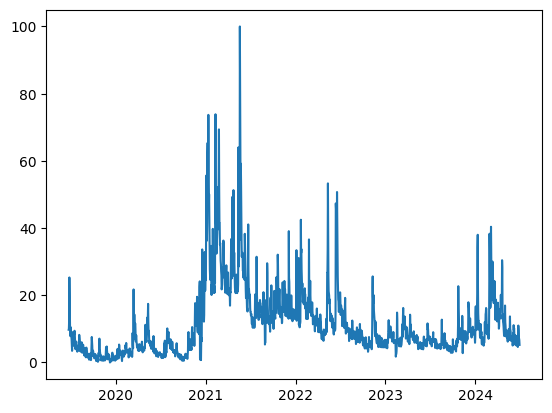

In [146]:
plt.plot(bitcoin_concat['Date'], bitcoin_concat['Normalized_Searches'])

כל מספר מתרגם לכמות מסויימת של חיפושים

להתאים בין כמות החיפושים באותו חודש למספר ולהבין כמה כל פיפס במנורמל מתרגם לכמות חיפושים

בודקים את היחס בין הכמות חיפושים לנרמול כפול כמות הנקודות

מגיעים למספר הממוצע של כל הנקודות בדאטא פריים הראשון

בכל שבוע יש ערך מנורמל וערך אבסולוטי ורוצים לראות בערך את אותו מספר בהתאם לחישוב היחסים

ווידוא שגלימפס עושים את העבודה כמו שצריך

לקחת את היחס בין חיפושים לקליקים ולראות אם הוא תואם בכל התקופה, בהתאם אפשר למצוא את הערכים לפי היחס

לוקחים את הגרף של החמש שנים היומי

כל נקודה מחסרים ממנה את המינימום של כל התקופה

ומחלקים במקסימום פחות המינימום כפול 100

********אולי לנסות אחר כך גם לפי שעתי או אפילו לפי דקה

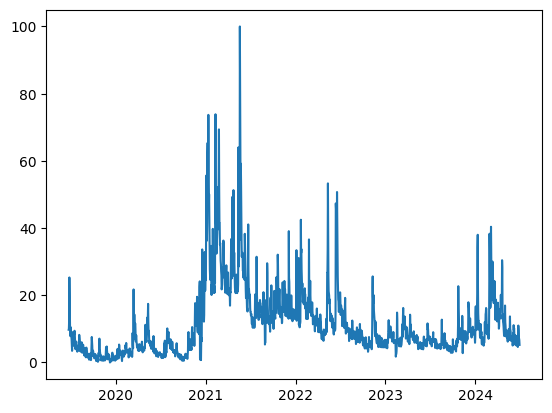

In [23]:
total1 = t1['Trend'].sum()
total2 = t2['Trend'].sum()

t1['Normalized'] = t1['Trend'] / total1 * 100
t2['Normalized'] = t2['Trend'] / total2 * 100

t1[]

# print(t1[t1['Date'] == '2023-10-03']['Trend'].values[0] / t2[t2['Date'] == '2023-10-03']['Trend'].values[0])
# print(t1[t1['Date'] == '2023-10-02']['Trend'].values[0] / t2[t2['Date'] == '2023-10-02']['Trend'].values[0])
# print(t1[t1['Date'] == '2023-10-01']['Trend'].values[0] / t2[t2['Date'] == '2023-10-01']['Trend'].values[0])

2.391304347826087
2.2222222222222223
2.3


In [4]:
# Calculate correlations for each category
volt_del_corr_general = [trend_corr(stock)[0] for stock in general_stocks]
volt_del_corr_tech = [trend_corr(stock)[0] for stock in tech_stocks]
volt_del_corr_finance = [trend_corr(stock)[0] for stock in finance_stocks]
volt_del_corr_crypto = [trend_corr(crypto)[0] for crypto in decentralized_currencies]

# Combine the results
volt_del_corr = volt_del_corr_general + volt_del_corr_tech + volt_del_corr_finance + volt_del_corr_crypto

# Create labels for the scatter plot
labels = general_stocks + tech_stocks + finance_stocks + decentralized_currencies

Trend Data for ['Shiba Inu'] retrieved successfully.
Stock Data for SHIB-USD retrieved successfully.


In [ ]:
# Plot the scatter plot
plt.figure(figsize=(16, 8))
plt.scatter(range(len(general_stocks)), volt_del_corr_general, color = color_map['general'], label = 'General Stocks')
for i in range(len(general_stocks)):
    plt.axvline(x = i, color = color_map['general'], linestyle = ':', alpha = 0.3)  # Add vertical lines to separate the stocks
plt.scatter(range(len(general_stocks), len(general_stocks) + len(tech_stocks)), volt_del_corr_tech, color = color_map['tech'], label = 'Tech Stocks')
for i in range(len(general_stocks), len(general_stocks) + len(tech_stocks)):
    plt.axvline(x = i, color = color_map['tech'], linestyle = ':', alpha = 0.3)  # Add vertical lines to separate the stocks
plt.scatter(range(len(general_stocks) + len(tech_stocks), len(general_stocks) + len(tech_stocks) + len(finance_stocks)), volt_del_corr_finance, color = color_map['finance'], label = 'Finance Stocks')
for i in range(len(general_stocks) + len(tech_stocks), len(general_stocks) + len(tech_stocks) + len(finance_stocks)):
    plt.axvline(x = i, color = color_map['finance'], linestyle = ':', alpha = 0.3)  # Add vertical lines to separate the stocks
plt.scatter(range(len(general_stocks) + len(tech_stocks) + len(finance_stocks), len(general_stocks) + len(tech_stocks) + len(finance_stocks) + len(decentralized_currencies)), volt_del_corr_crypto, color = color_map['crypto'], label = 'Decentralized Currencies')
for i in range(len(general_stocks) + len(tech_stocks) + len(finance_stocks), len(general_stocks) + len(tech_stocks) + len(finance_stocks) + len(decentralized_currencies)):
    plt.axvline(x = i, color = color_map['crypto'], linestyle = ':', alpha = 0.3)  # Add vertical lines to separate the stocks
plt.axhline(y = 0, color = 'black', linestyle = '--')  # Add a horizontal line at y = 0
plt.xlabel('Assets')
plt.ylabel('Correlation with 7-Day Delayed Trend')
plt.title('Correlation of Close Price and 7-Day Delayed Trend')
legend = plt.legend()
legend.get_frame().set_alpha(0.3)
plt.xticks(range(len(labels)), labels, rotation = 60)
plt.tight_layout(pad = 2)
plt.savefig('Correlation_Scatter_Plot.png')
plt.show()

# Print the correlation values and their mean
print(volt_del_corr, np.mean(volt_del_corr))

In [ ]:
# Plot for each stock and decentralized currency
for stock in general_stocks + tech_stocks + finance_stocks + decentralized_currencies:
    plot_stock_data(stock, download = True)